참고 코드
*   텐서플로우 튜토리얼 (https://www.tensorflow.org/tutorials/)
*   머신 러닝 교과서 with 파이썬, 사이킷런, 텐서플로 개정 3판 (https://github.com/gilbutITbook/080223)
*   핸즈온 머신러닝 2판 (https://github.com/rickiepark/handson-ml2)
*   케라스 창시자에게 배우는 딥러닝 (https://github.com/rickiepark/deep-learning-with-python-notebooks/tree/tf2)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from IPython.display import Image
import glob
import imageio
import os
import PIL
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# [1] 오토 인코더 실습

## 1.1. F-MNIST 데이터셋 로드하기

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## 1.2. 기본 오토 인코더

### 1.2.1. 모델 정의

In [3]:
latent_dim  = 8

encoder = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(latent_dim, activation='relu'),
], name = 'encoder')

decoder = tf.keras.Sequential([
  tf.keras.layers.Dense(784, activation='sigmoid'),
  tf.keras.layers.Reshape((28, 28))
], name = 'decoder')

autoencoder = tf.keras.Sequential([encoder, decoder])

In [4]:
autoencoder.build(input_shape=(None, 28, 28))
autoencoder.compile(optimizer='adam', 
                    loss=tf.keras.losses.MeanSquaredError())

In [5]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
_________________________________________________________________


In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               7056      
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 7,056
Trainable params: 7,056
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 8)                 6280      
_________________________________________________________________
decoder (Sequential)         (None, 28, 28)            7056      
Total params: 13,336
Trainable params: 13,336
Non-trainable params: 0
_________________________________________________________________


### 1.2.2. 모델 훈련

In [8]:
history = autoencoder.fit(x_train, x_train, # x->x_train, y->x_train 
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.0416 - val_loss: 0.0272
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0236 - val_loss: 0.0235
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0235 - val_loss: 0.0235
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0234 - val_loss: 0.0233
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.023

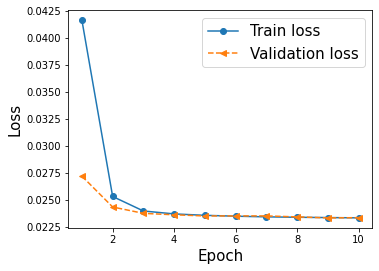

In [9]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

### 1.2.3. 결과 테스트

In [10]:
encoded_imgs = autoencoder.get_layer('encoder')(x_test).numpy()
decoded_imgs = autoencoder.get_layer('decoder')(encoded_imgs).numpy()

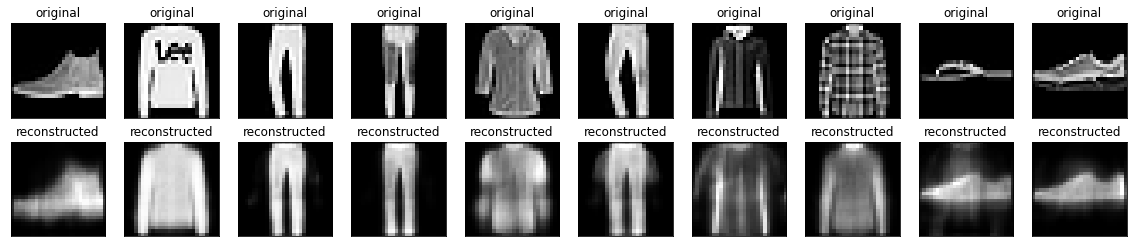

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 1.3. 합성곱 오토 인코더

In [12]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [13]:
latent_dim  = 8

conv_encoder = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2, input_shape = (28, 28, 1)),
  tf.keras.layers.Conv2D(latent_dim, (3,3), activation='relu', padding='same', strides=2)
], name = 'conv_encoder')

conv_decoder = tf.keras.Sequential([
  tf.keras.layers.Conv2DTranspose(latent_dim, kernel_size=3, strides=2, activation='relu', padding='same'), #Deconvolution
  tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), #Deconvolution
  tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
], name = 'conv_decoder')

conv_autoencoder = tf.keras.Sequential([conv_encoder, conv_decoder])

In [14]:
conv_encoder.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [15]:
conv_decoder.summary()

Model: "conv_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [16]:
conv_autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_encoder (Sequential)    (None, 7, 7, 8)           1320      
_________________________________________________________________
conv_decoder (Sequential)    (None, 28, 28, 1)         1897      
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [17]:
conv_autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
history = conv_autoencoder.fit(x_train, x_train, # x->x_train, y->x_train 
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 34s 3ms/step - loss: 0.0125 - val_loss: 0.0054
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.00

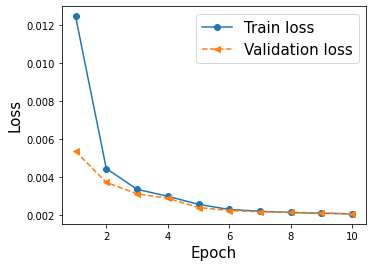

In [18]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

In [19]:
conv_encoded_imgs = conv_autoencoder.get_layer('conv_encoder')(x_test).numpy()
conv_decoded_imgs = conv_autoencoder.get_layer('conv_decoder')(conv_encoded_imgs).numpy()

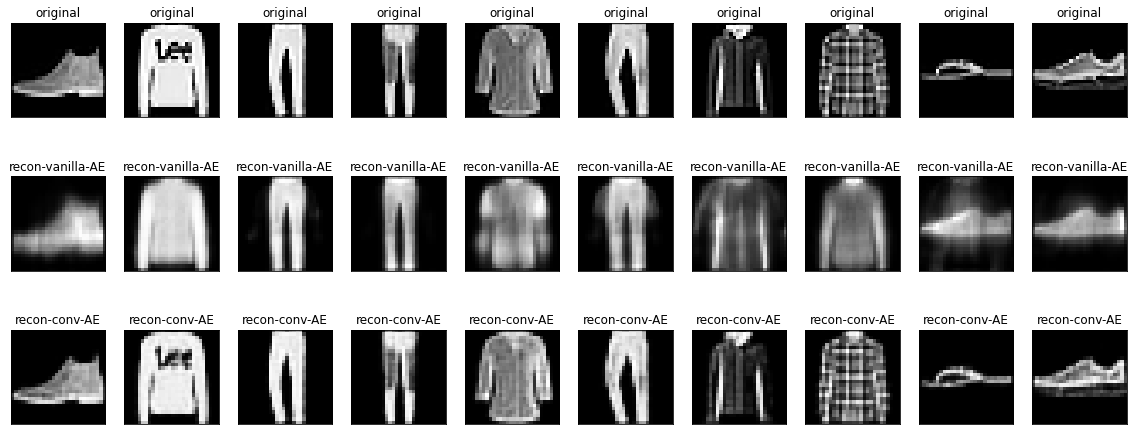

In [20]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i][...,0])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (vanilla AE)
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("recon-vanilla-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (convolutional AE)
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(conv_decoded_imgs[i][...,0])
  plt.title("recon-conv-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## 1.4. 디노이징 오토 인코더

In [21]:
# 정규 분포 노이즈
tf.random.normal(shape=(1,10)) 

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.09016925, -0.2821923 , -0.95267814, -1.3444105 ,  0.40626407,
        -1.0947485 ,  0.27708694, -1.2915964 , -0.84541094,  0.48007187]],
      dtype=float32)>

In [22]:
# 이미지에 노이즈를 추가
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) # 0에서 1 사이 값으로
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.) # 0에서 1 사이 값으로

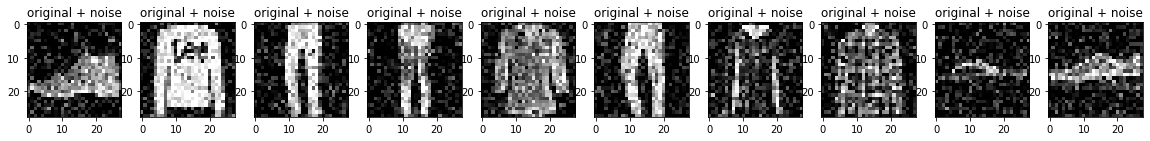

In [23]:
#노이즈가 추가된 이미지 확인
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[...,0][i])
    plt.gray()
plt.show()

In [24]:
latent_dim  = 8

deno_conv_encoder = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2, input_shape = (28, 28, 1)),
  tf.keras.layers.Conv2D(latent_dim, (3,3), activation='relu', padding='same', strides=2)
], name = 'deno_conv_encoder')

deno_conv_decoder = tf.keras.Sequential([
  tf.keras.layers.Conv2DTranspose(latent_dim, kernel_size=3, strides=2, activation='relu', padding='same'), #Deconvolution
  tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'), #Deconvolution
  tf.keras.layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
], name = 'deno_conv_decoder')

deno_conv_autoencoder = tf.keras.Sequential([deno_conv_encoder, deno_conv_decoder])

In [25]:
deno_conv_autoencoder.compile(optimizer='adam', 
                              loss=tf.keras.losses.MeanSquaredError())
history = deno_conv_autoencoder.fit(x_train_noisy, x_train, #x->x_train_noisy, y->x_train
                epochs=20,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0168 - val_loss: 0.0099
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.007

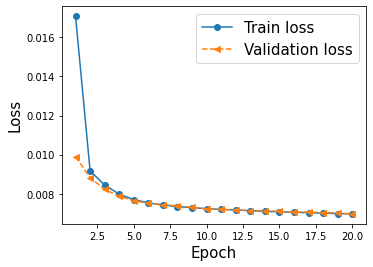

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

### 1.4.1. 노이즈가 없는 경우

In [26]:
deno_conv_encoded_imgs = deno_conv_autoencoder.get_layer('deno_conv_encoder')(x_test).numpy() #x_test -> 노이즈 없는 원본 이미지
deno_conv_decoded_imgs = deno_conv_autoencoder.get_layer('deno_conv_decoder')(deno_conv_encoded_imgs).numpy()

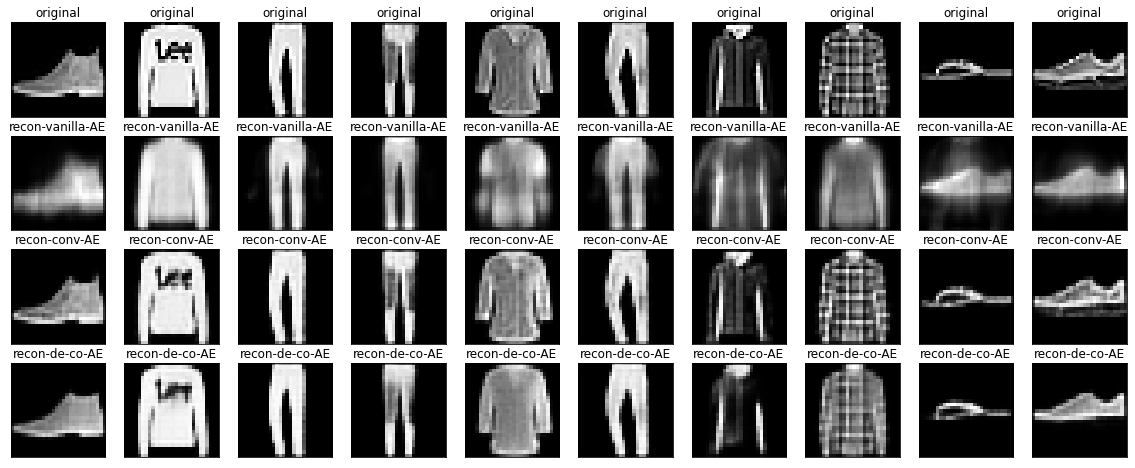

In [27]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(4, n, i + 1)
  plt.imshow(x_test[i][...,0])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (vanilla AE)
  ax = plt.subplot(4, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("recon-vanilla-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (conv AE)
  ax = plt.subplot(4, n, i + 1 + 2*n)
  plt.imshow(conv_decoded_imgs[i][...,0])
  plt.title("recon-conv-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (denoising AE)
  ax = plt.subplot(4, n, i + 1 + 3*n)
  plt.imshow(deno_conv_decoded_imgs[i][...,0])
  plt.title("recon-de-co-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

### 1.4.2. 노이즈가 있는 경우

In [28]:
encoded_noisy_imgs = autoencoder.get_layer('encoder')(x_test_noisy[...,0]).numpy() #x_text_noisy -> 노이즈 있는 이미지
decoded_noisy_imgs = autoencoder.get_layer('decoder')(encoded_noisy_imgs).numpy()

conv_encoded_noisy_imgs = conv_autoencoder.get_layer('conv_encoder')(x_test_noisy).numpy() #x_text_noisy -> 노이즈 있는 이미지
conv_decoded_noisy_imgs = conv_autoencoder.get_layer('conv_decoder')(conv_encoded_noisy_imgs).numpy()

deno_conv_encoded_noisy_imgs = deno_conv_autoencoder.get_layer('deno_conv_encoder')(x_test_noisy).numpy() #x_text_noisy -> 노이즈 있는 이미지
deno_conv_decoded_noisy_imgs = deno_conv_autoencoder.get_layer('deno_conv_decoder')(deno_conv_encoded_noisy_imgs).numpy()

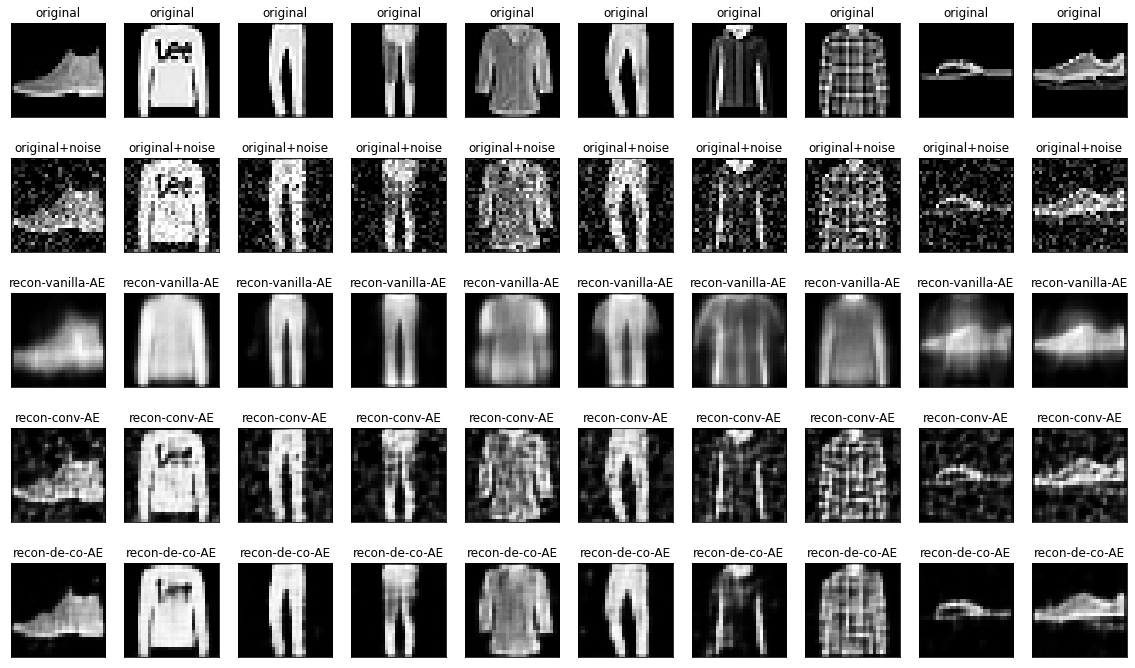

In [29]:
n = 10
plt.figure(figsize=(20, 12))
for i in range(n):
  # display original
  ax = plt.subplot(5, n, i + 1)
  plt.imshow(x_test[i][...,0])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display original+noise
  ax = plt.subplot(5, n, i + 1 + n)
  plt.imshow(x_test_noisy[i][...,0])
  plt.title("original+noise")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (vanilla AE)
  ax = plt.subplot(5, n, i + 1 + 2*n)
  plt.imshow(decoded_noisy_imgs[i])
  plt.title("recon-vanilla-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (conv AE)
  ax = plt.subplot(5, n, i + 1 + 3*n)
  plt.imshow(conv_decoded_noisy_imgs[i][...,0])
  plt.title("recon-conv-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction (denoising AE)
  ax = plt.subplot(5, n, i + 1 + 4*n)
  plt.imshow(deno_conv_decoded_noisy_imgs[i][...,0])
  plt.title("recon-de-co-AE")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# [2] 오토 인코더 응용 - 이상치 탐지

In [ ]:
#심전도(ECG) 데이터
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/420px-SinusRhythmLabels.svg.png',width=300)

In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/b/bd/12leadECG.jpg', width = 1000)

## 2.1. ECG 데이터 로드하기


*   데이터 출처: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
*   140개의 특징값이 있는 5,000개의 심전도 데이터 셋
*   레이블: '0'(비정상) 또는 '1'(정상)


In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
raw_data = dataframe.values

data = raw_data[:, 0:-1] 
labels = raw_data[:, -1] #마지막 값은 label

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
#데이터를 0에서 1 사이 값으로 정규화

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
normal_train_data = train_data[train_labels==1]
normal_test_data = test_data[test_labels==1]

anomalous_train_data = train_data[train_labels==0]
anomalous_test_data = test_data[test_labels==0]

In [ ]:
#train_data 에서의 정상/비정상 비율
print('정상 비율: {:3.1f}%'.format((normal_train_data.shape[0]/train_data.shape[0])*100))
print('비정상 비율: {:3.1f}%'.format((anomalous_train_data.shape[0]/train_data.shape[0])*100))

정상 비율: 59.0%
비정상 비율: 41.0%


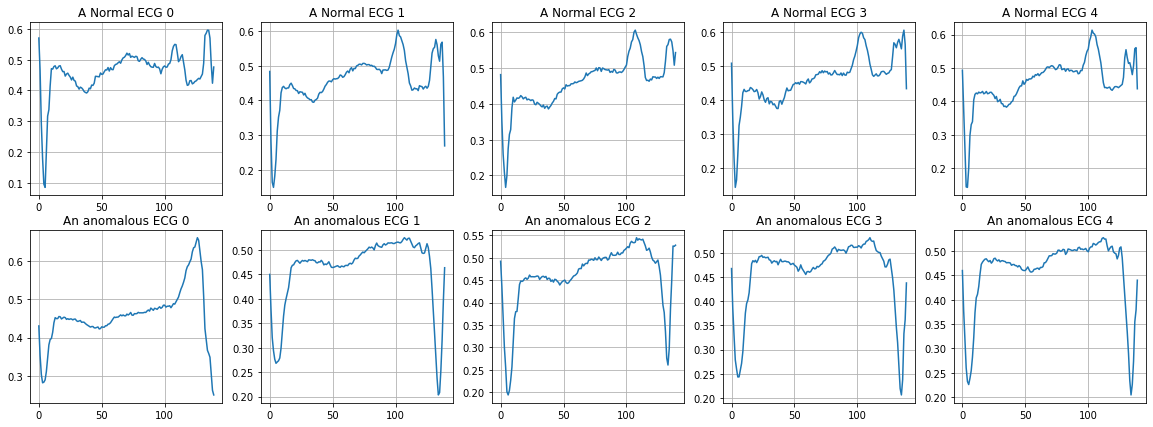

In [ ]:
#정상/비정상 ECG 형태 비교
n = 5
plt.figure(figsize=(20, 7))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.grid()
  plt.plot(np.arange(140), normal_train_data[i])
  plt.title("A Normal ECG "+str(i))

  ax = plt.subplot(2, n, n+i+1)
  plt.grid()
  plt.plot(np.arange(140), anomalous_train_data[i])
  plt.title("An anomalous ECG "+str(i))

plt.show()

## 2.2. 모델 생성 및 훈련

In [ ]:
ano_encoder = tf.keras.Sequential([
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
], name = 'ano_encoder')

ano_decoder = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(140, activation="sigmoid")
], name = 'ano_decoder')

ano_autoencoder = tf.keras.Sequential([ano_encoder, ano_decoder])
ano_autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = ano_autoencoder.fit(normal_train_data, normal_train_data, #normal 로만 훈련
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 36ms/step - loss: 0.0578 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0552 - val_loss: 0.0516
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0524 - val_loss: 0.0495
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0490 - val_loss: 0.0478
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0454 - val_loss: 0.0457
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0417 - val_loss: 0.0438
Epoch 7/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0383 - val_loss: 0.0421
Epoch 8/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.0406
Epoch 9/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0326 - val_loss: 0.0394
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0382
Epoch 11/20
5/5 [=====================

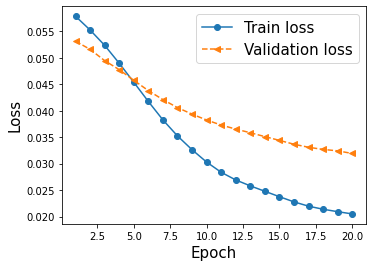

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
plt.show()

## 2.3. 결과 테스트

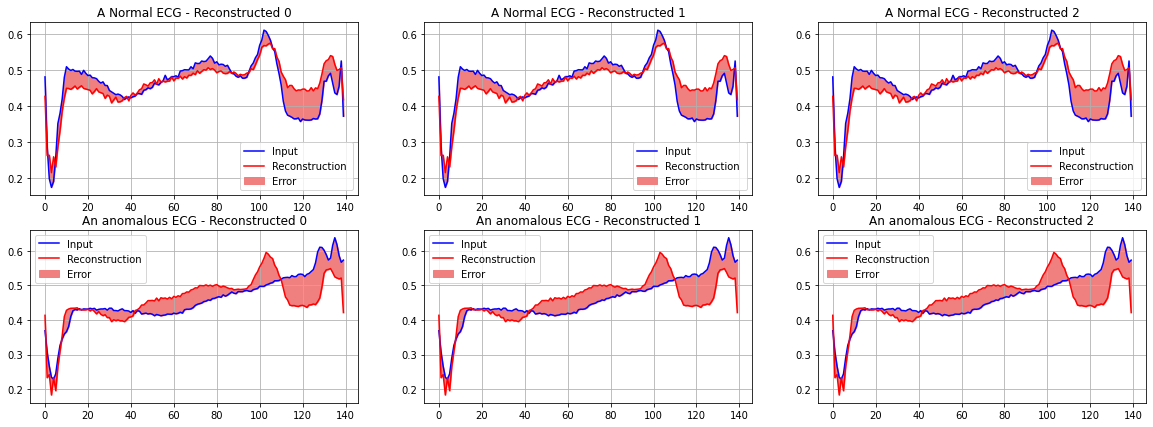

In [ ]:
normal_encoded_imgs = ano_autoencoder.get_layer('ano_encoder')(normal_test_data).numpy()
normal_decoded_imgs = ano_autoencoder.get_layer('ano_decoder')(normal_encoded_imgs).numpy()

anomal_encoded_imgs = ano_autoencoder.get_layer('ano_encoder')(anomalous_test_data).numpy()
anomal_decoded_imgs = ano_autoencoder.get_layer('ano_decoder')(anomal_encoded_imgs).numpy()

n = 3
plt.figure(figsize=(20, 7))
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.grid()
  plt.plot(np.arange(140), normal_test_data[0], 'b')
  plt.plot(np.arange(140), normal_decoded_imgs[0], 'r')
  plt.fill_between(np.arange(140), normal_decoded_imgs[0], normal_test_data[0], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction ", "Error"])
  plt.title("A Normal ECG - Reconstructed "+str(i))

  ax = plt.subplot(2, n, n+i+1)
  plt.grid()
  plt.plot(np.arange(140), anomalous_test_data[0], 'b')
  plt.plot(np.arange(140), anomal_decoded_imgs[0], 'r')
  plt.fill_between(np.arange(140), anomal_decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.title("An anomalous ECG - Reconstructed "+str(i))

plt.show()

## 이상치 기준값 설정

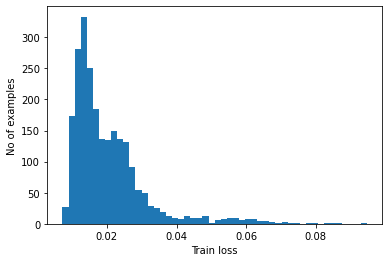

In [ ]:
#훈련 데이터셋의 정상 ECG에 대한 reconstruction error (loss) 분포
reconstructions = ano_autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
# mean+1std 를 threshold로 설정
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03127298


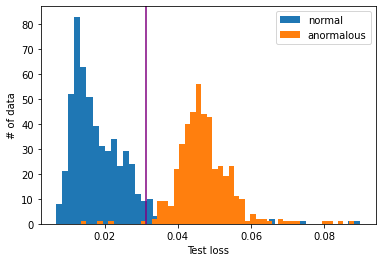

In [ ]:
#테스트 데이터 셋의 정상/비정상 ECG에 대한 reconstruction error (loss) 분포 -> 실제로 threshold를 기준으로 나뉨

reconstructions = ano_autoencoder.predict(normal_test_data)
test_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

ano_reconstructions = ano_autoencoder.predict(anomalous_test_data)
ano_test_loss = tf.keras.losses.mae(ano_reconstructions, anomalous_test_data)


plt.hist(test_loss, bins=50, label = 'normal')
plt.hist(ano_test_loss, bins=50, label = 'anormalous')
plt.axvline(x=threshold, c='purple')
plt.xlabel("Test loss")
plt.ylabel("# of data")
plt.legend()
plt.show()

In [ ]:
#Accuracy, Precision, Recall 테스트

reconstructions = ano_autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
preds = tf.math.less(loss, threshold)

print("Accuracy:", accuracy_score(test_labels, preds)) 
print("Precision:", precision_score(test_labels, preds)) # ()
print("Recall:", recall_score(test_labels, preds)) # TP/(TP+FN)

Accuracy: 0.941
Precision: 0.9921414538310412
Recall: 0.9017857142857143


In [ ]:
Image(url='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fyc4QD%2Fbtq0ZLH3kgB%2FzUqcvWoyfgwfmLSwSo5TNK%2Fimg.png', width=600)

# [3] 생성적 적대 신경망 (GAN) 실습

## 3.1. MNIST 데이터셋 로딩하기

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

## 3.2. 모델 정의

### 3.2.1. 생성자 모델

In [ ]:
#생성자: 24개의 랜덤 시드값을 28x28 벡터 값(이미지로 해석될)으로 Conv2DTranspose 층을 통해 업샘플링

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(2,))) # (input shape 100차원 기본)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 128))) 

    model.add(tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)) #output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
 
    model.add(tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')) #output_shape == (None, 28, 28, 1)

    return model

tf.Tensor([[-0.7447953  -0.76572543]], shape=(1, 2), dtype=float32)
(1, 2)


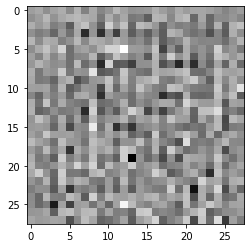

In [ ]:
# 초기화된 생성자 모델 테스트
generator = make_generator_model()

noise = tf.random.normal([1, 2]) #normal distributuion으로 2차원 데이터 1개 샘플링 (100차원 기본)
print(noise)
print(noise.shape)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 3.2.2. 판별자 모델 

In [ ]:
#판별자: 합성곱 신경망 기반의 이미지 분류기
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [ ]:
# 초기화된 판별자 모델 테스트 

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.numpy()) # 진짜 이미지는 양수값, 가짜 이미지는 음수값을 가지는 것으로 훈련 계획

[[-0.00073947]]


## 3.3. 손실함수와 옵티마이저 정의

In [ ]:
# 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환 (from_logits 중복 호출 에러 방지)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 3.3.1. 판별자 손실함수


*  판별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는가?
*  진짜 이미지에 대한 판별자의 예측과 1로 이루어진 행렬을 비교
*  가짜 (생성된) 이미지에 대한 판별자의 예측과 0으로 이루어진 행렬을 비교

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 3.3.2. 생성자 손실함수

*   생성자가 감별자를 얼마나 잘 속였는가?
*   생성자가 잘 작동한다면 판별자는 가짜 이미지를 진짜(1)로 분류
*   생성된 이미지에 대한 판별자의 예측을 1로 이루어진 행렬과 비교

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 3.3.3. 옵티마이저

In [ ]:
# 생성자와 판별자는 각각 따로 최적화됨
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 3.3. 모델 훈련

In [ ]:
EPOCHS = 50
noise_dim = 2 #100차원 기본
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim]) #이미지 생성을 위한 시드 (고정)

In [ ]:
#이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False) # 모델을 추론 모드로 실행 

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
#생성자 모델과 판별자 모델 훈련 스텝. 
#진짜 이미지를 입력받고 또 노이즈로 가짜 이미지 생성 -> 로스 계산 -> 그래디언트 계산 -> 가중치 업데이트
@tf.function # 함수를 호출 가능한 TensorFlow 그래프로 컴파일 - 빠른 실행
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

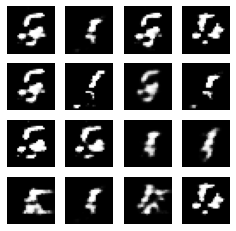

Time for epoch 27 is 11.393 sec


KeyboardInterrupt: ignored

In [ ]:
epochs = 50
for epoch in range(epochs):
  start = time.time()

  for image_batch in train_dataset:
    train_step(image_batch)

  display.clear_output(wait=True)
  generate_and_save_images(generator, epoch + 1, seed)
  print ('Time for epoch {} is {:.3f} sec'.format(epoch + 1, time.time()-start))

display.clear_output(wait=True)
generate_and_save_images(generator, epochs, seed)

## 3.4. For fun 1: 훈련 GIF 생성

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.5. For fun 2: 생성자 모델로 새로운 이미지 생성

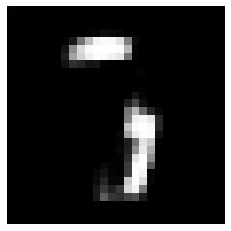

In [ ]:
new_seed = tf.random.normal([1, 2])
predictions = generator(new_seed, training=False) # 모델을 추론 모드로 실행 

fig = plt.figure(figsize=(4,4))
plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()

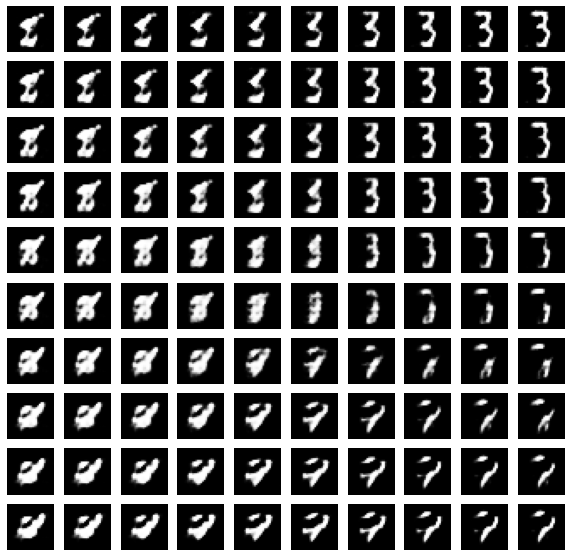

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(10):
    temp_seed = tf.constant([[(i-5)/5,(j-5)/5]])
    predictions = generator(temp_seed, training=False)
    ax = plt.subplot(10, 10, i*10+j+1)
    plt.axis('off')
    plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')